In [11]:
import pandas as pd
import geopandas as gpd

import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

In [17]:
# loading the London Wards boundaries shapefile data and obesity data
gdf = gpd.read_file("statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp")
data = pd.read_csv('data.csv')
gdf.shape

(625, 8)

In [19]:
# merge the obesity data with ward level shapefile by the ward_code
gdf_obesity = pd.merge(gdf,data,left_on='GSS_CODE', right_on='ward_code', how='left')
gdf_obesity.head(5)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,ward_code,Ward,...,Unauthorised_Absence_in_All_Schools,Median_Household_income,Qualifications_Level4_and_above,Population_density,Households_with_access_to_openspace,Road_Casualties,People_activities_are_limited,People_with_Bad_or_Very_Bad_Health,Average_GCSE,Unemployed
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",E05000405,Chessington South,...,0.62,38310,25.3,1348.684211,68.51,30.00,5.6,3.6,43.758998,5.138962
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.6 165447.1, 517837.1 165469.4...",E05000414,Tolworth and Hook Rise,...,0.59,37840,30.0,3788.461538,10.82,44.33,5.3,3.8,45.071700,5.727924
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.5 167303.4, 518114.3 167307.5...",E05000401,Berrylands,...,0.50,42330,48.4,6300.000000,23.65,10.33,6.2,4.1,59.567913,5.863254
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480 166909.8, 520490.7 166901.9, ...",E05000400,Alexandra,...,0.35,41390,32.7,3425.925926,43.37,24.67,5.1,3.3,71.637937,5.444833
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071 168144.9, 522063.9 168144, 52...",E05000402,Beverley,...,0.69,40700,41.7,5342.105263,2.52,26.33,6.5,4.4,59.166964,6.372920


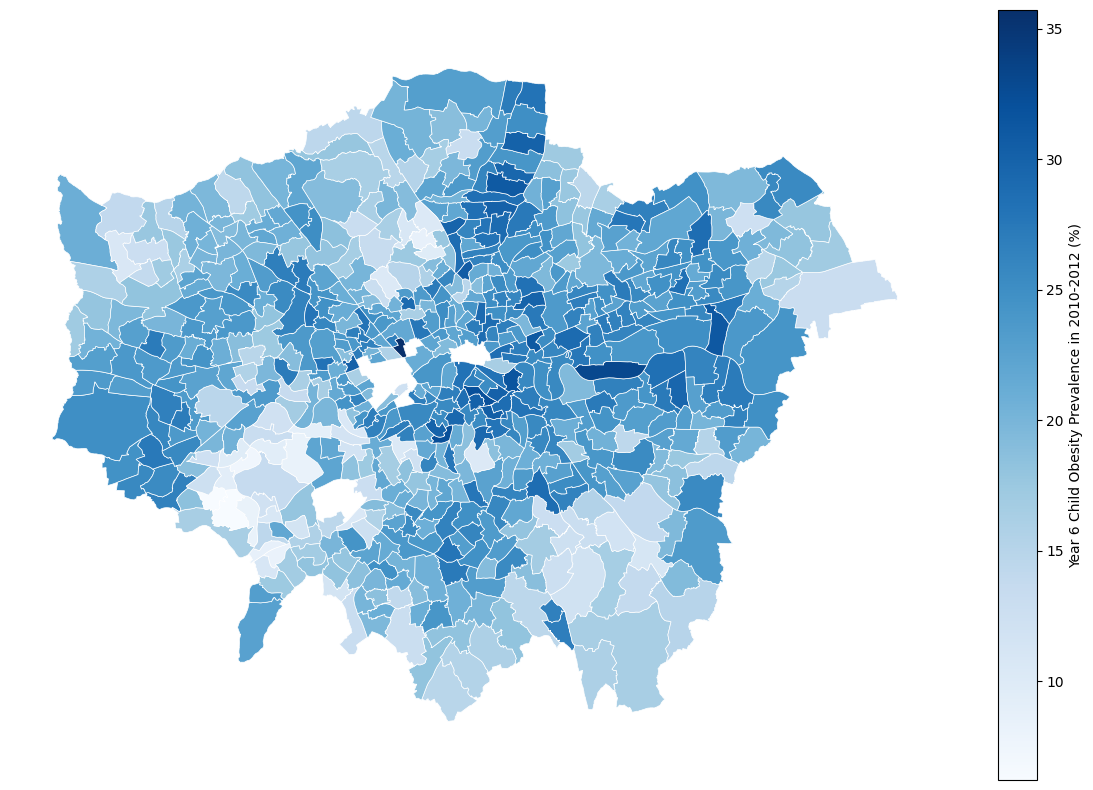

In [20]:
# define a function to plot the obesity distribution map and save the figure
def obesityPlot():
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    gdf_obesity.plot(edgecolor=(1, 1, 1, 1),linewidth=0.5, column='Childhood_Obesity_Year6',cmap='Blues',
                            legend=True,legend_kwds={'label': "Year 6 Child Obesity Prevalence in 2010-2012 (%)"},ax=ax)
    
    #ax.set_title("Figure 1: The distribution of Children Obesity Prevalence in London \nfor each ward (except City of London) from 2010 to 2012", fontsize=16)
    ax.axis('off')
    #plt.savefig("obesity_map.jpg", dpi=300, bbox_inches='tight')
    plt.show()

obesityPlot()

In [ ]:
# show the column names of the dataset for regression
print(data.columns)
# check the dataset's size - 625 wards in London
data.shape

Index(['ward_code', 'Ward', 'Borough', 'Childhood_Obesity_Year6',
       'Children_in_poverty', 'dependent_children_in_out_of_work_households',
       'Public_Transport_Accessibility', 'Crime_rate',
       'Unauthorised_Absence_in_All_Schools', 'Median_Household_income',
       'Qualifications_Level4_and_above', 'Population_density',
       'Households_with_access_to_openspace', 'Road_Casualties',
       'People_activities_are_limited', 'People_with_Bad_or_Very_Bad_Health',
       'Average_GCSE', 'Unemployed'],
      dtype='object')


(625, 18)

In [24]:
# check the missing value / Null value in the dataset
print(data.isnull().sum())

ward_code                                        0
Ward                                             0
Borough                                          0
Childhood_Obesity_Year6                         12
Children_in_poverty                              0
dependent_children_in_out_of_work_households     0
Public_Transport_Accessibility                   0
Crime_rate                                       0
Unauthorised_Absence_in_All_Schools              0
Median_Household_income                          0
Qualifications_Level4_and_above                  0
Population_density                               0
Households_with_access_to_openspace              0
Road_Casualties                                  0
People_activities_are_limited                    0
People_with_Bad_or_Very_Bad_Health               0
Average_GCSE                                     0
Unemployed                                       0
dtype: int64


<Axes: xlabel='Households_with_access_to_openspace', ylabel='Childhood_Obesity_Year6'>

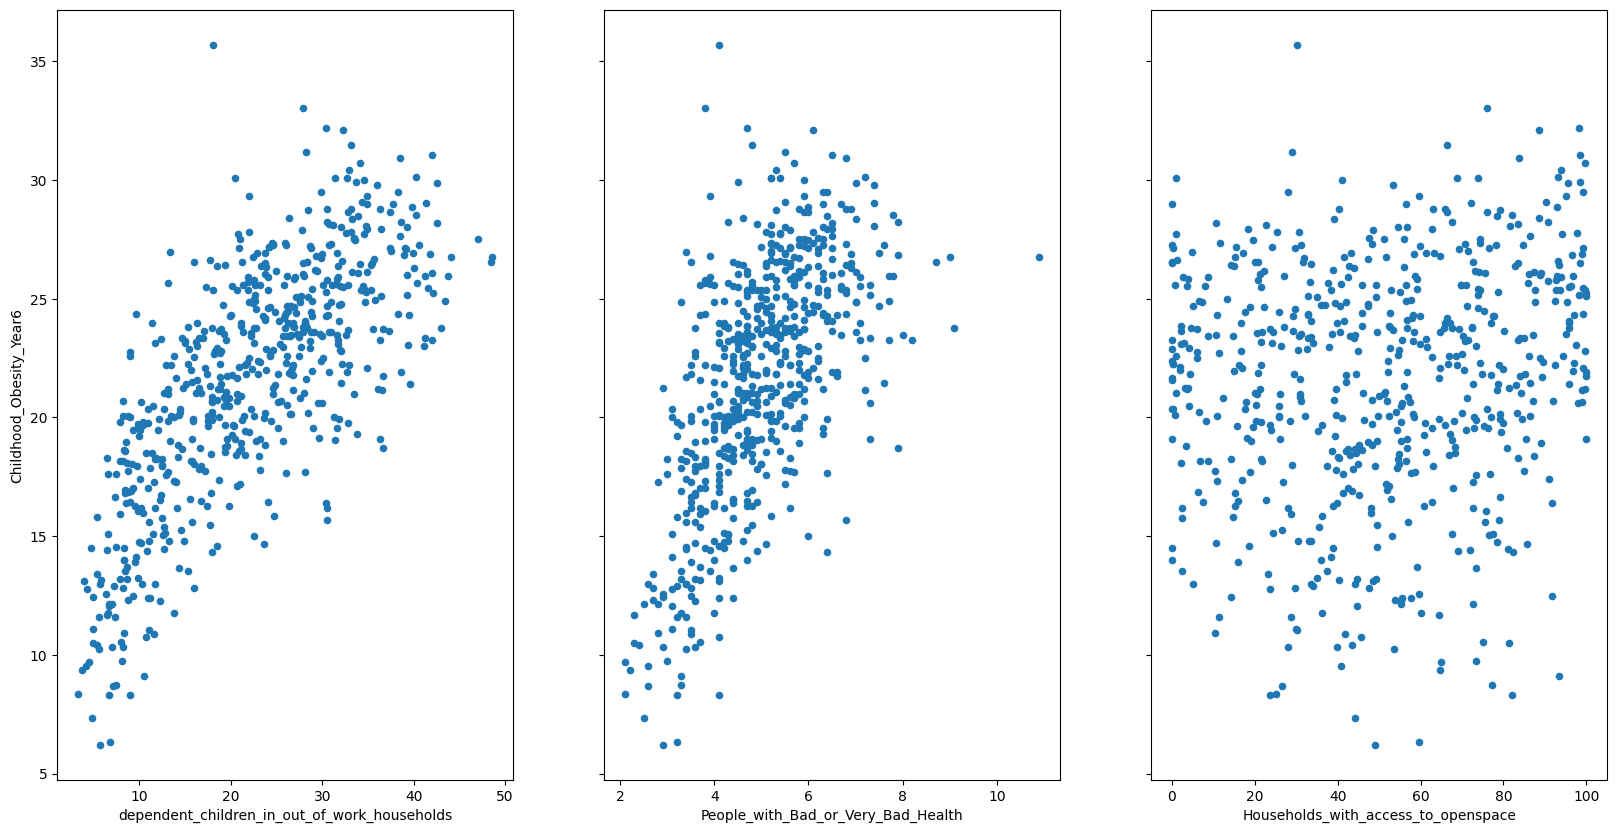

In [25]:
# plot some of the distribution of the indicators I selected initially, and check the relationship with child obesity...
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='dependent_children_in_out_of_work_households', y='Childhood_Obesity_Year6', ax=axs[0], figsize=(20, 10))
data.plot(kind='scatter', x='People_with_Bad_or_Very_Bad_Health', y='Childhood_Obesity_Year6', ax=axs[1], figsize=(20, 10))
data.plot(kind='scatter', x='Households_with_access_to_openspace', y='Childhood_Obesity_Year6', ax=axs[2], figsize=(20, 10))

In [ ]:
# create a new dataframe for descriptive stastics
df_des = data[['Childhood_Obesity_Year6',
       'Children_in_poverty', 'dependent_children_in_out_of_work_households', 'Median_Household_income','Unemployed','Qualifications_Level4_and_above',
       'Average_GCSE','Unauthorised_Absence_in_All_Schools', 'Crime_rate','Road_Casualties','People_activities_are_limited', 'People_with_Bad_or_Very_Bad_Health',
       'Public_Transport_Accessibility', 'Population_density','Households_with_access_to_openspace']]

In [27]:
# descriptive analysis
summary = df_des.describe().T
# calculate the skewness for each indicator to evaluate the data distribution
summary['Skewness'] = df_des.skew()
# calculate the kurtosis to evaluate the tail features for indicators
summary['Kurtosis'] = df_des.kurtosis()

print(summary)
#summary.to_csv("descriptive_stastics.csv", index=False)

                                              count          mean  \
Childhood_Obesity_Year6                       613.0     21.539266   
Children_in_poverty                           625.0     24.489808   
dependent_children_in_out_of_work_households  625.0     21.899968   
Median_Household_income                       625.0  39263.696000   
Unemployed                                    625.0      8.727768   
Qualifications_Level4_and_above               625.0     37.657760   
Average_GCSE                                  625.0     44.888378   
Unauthorised_Absence_in_All_Schools           625.0      1.065920   
Crime_rate                                    625.0     96.454128   
Road_Casualties                               625.0     46.356912   
People_activities_are_limited                 625.0      6.726240   
People_with_Bad_or_Very_Bad_Health            625.0      4.921760   
Public_Transport_Accessibility                625.0      3.676064   
Population_density                

In [ ]:
# subset the transformed variables
df = data[['Childhood_Obesity_Year6',
           'Children_in_poverty', 'dependent_children_in_out_of_work_households','Median_Household_income','Unemployed','Qualifications_Level4_and_above',
           'Average_GCSE','Unauthorised_Absence_in_All_Schools', 'Crime_rate', 'Road_Casualties','People_activities_are_limited', 'People_with_Bad_or_Very_Bad_Health',
           'Public_Transport_Accessibility', 'Population_density','Households_with_access_to_openspace']]
# drop the null/NA value, here 12 wards that was not in 2010-2012 wards list is droped
df = df.dropna()
# new df have 613 wards
print(df.shape)

# transform the data based on the data distribution and tail features by log-transformation / boxcox
from scipy.stats import boxcox
# add the transformed data columns to the df
df['Median_Household_income_log']= np.log1p(df['Median_Household_income'])
df['Crime_rate_log']= np.log1p(df['Crime_rate'])
df['Road_Casualties_log']= np.log1p(df['Road_Casualties'])
df['Public_Transport_Accessibility_log'] = np.log1p(df['Public_Transport_Accessibility'])
df['Population_density_boxcox'], _ = boxcox(df['Population_density'])

(613, 15)


In [ ]:
# new df with transformed data(without raw data)
df = df[['Childhood_Obesity_Year6',
        'Children_in_poverty', 'dependent_children_in_out_of_work_households','Median_Household_income_log','Unemployed','Qualifications_Level4_and_above',
        'Average_GCSE','Unauthorised_Absence_in_All_Schools', 'Crime_rate_log', 'Road_Casualties_log','People_activities_are_limited', 'People_with_Bad_or_Very_Bad_Health',
        'Public_Transport_Accessibility_log','Population_density_boxcox','Households_with_access_to_openspace']]

In [ ]:
# new descriptive analysis
summary1 = df.describe().T
summary1['Skewness'] = df.skew()
summary1['Kurtosis'] = df.kurtosis()
print(summary1)

                                              count       mean        std  \
Childhood_Obesity_Year6                       613.0  21.539266   5.062014   
Children_in_poverty                           613.0  24.807504  10.540165   
dependent_children_in_out_of_work_households  613.0  22.203002  10.001039   
Median_Household_income_log                   613.0  10.552201   0.167823   
Unemployed                                    613.0   8.812475   3.247264   
Qualifications_Level4_and_above               613.0  37.216803  12.569718   
Average_GCSE                                  613.0  44.557490  17.301647   
Unauthorised_Absence_in_All_Schools           613.0   1.073997   0.370310   
Crime_rate_log                                613.0   4.524686   0.337622   
Road_Casualties_log                           613.0   3.691280   0.542597   
People_activities_are_limited                 613.0   6.784176   1.397837   
People_with_Bad_or_Very_Bad_Health            613.0   4.965742   1.231703   

In [33]:
# z-score normolisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# normalize the data 
df_standardized = scaler.fit_transform(df)
# new dataframe named 'df_standardized' 
df_standardized = pd.DataFrame(df_standardized, columns=df.columns)

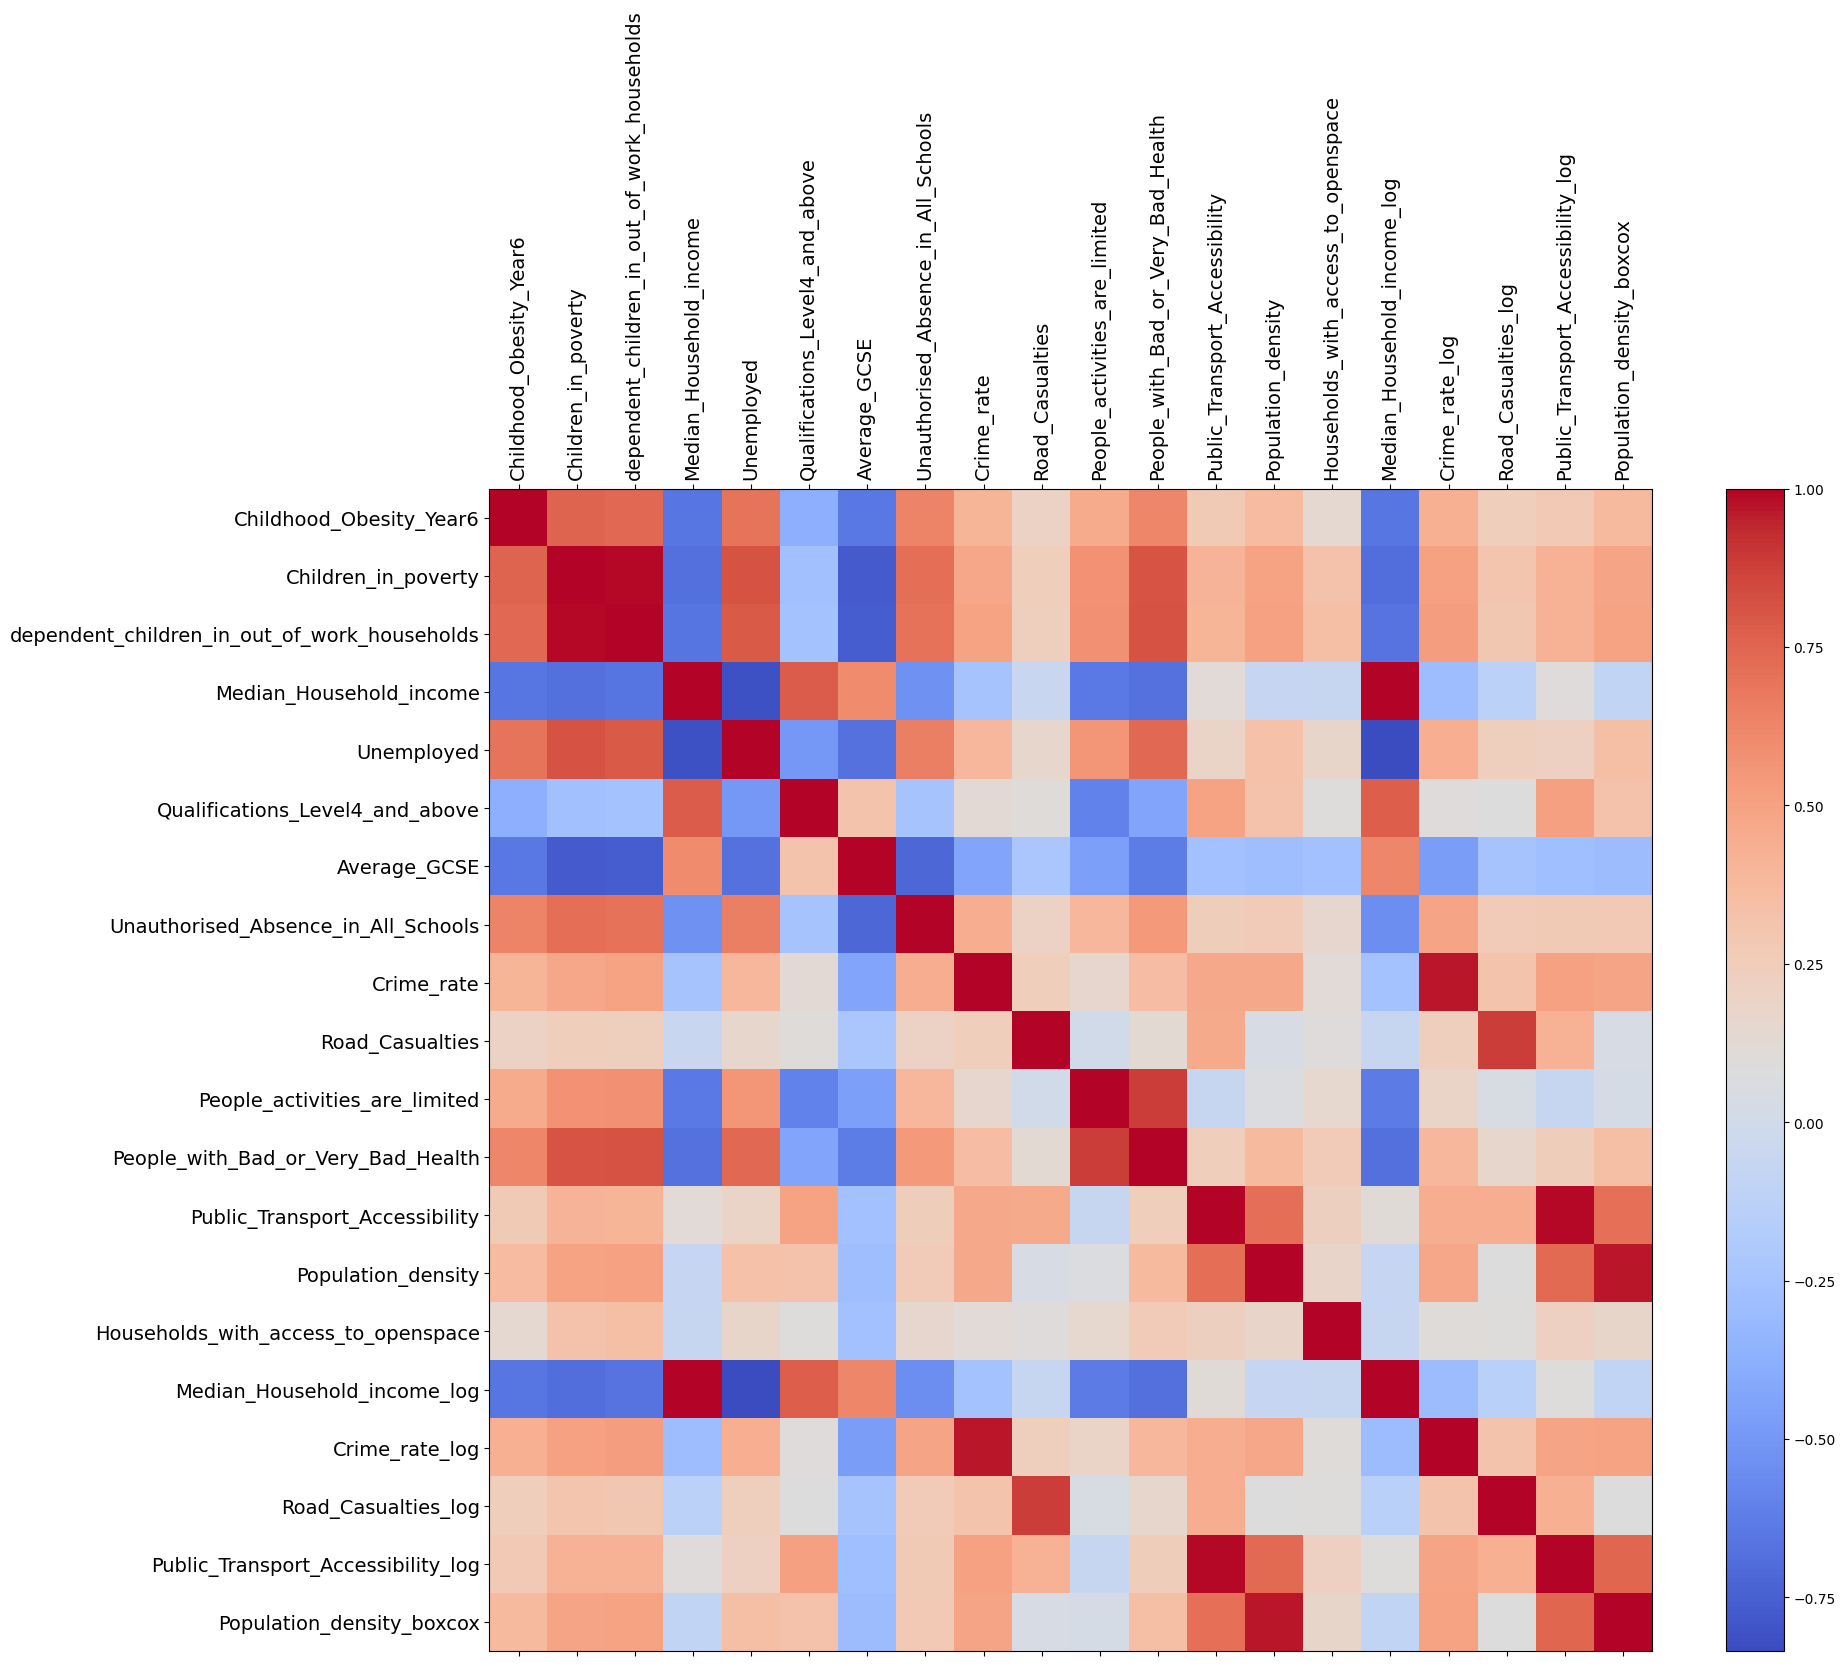

,Childhood_Obesity_Year6,Children_in_poverty,dependent_children_in_out_of_work_households,Median_Household_income,Unemployed,Qualifications_Level4_and_above,Average_GCSE,Unauthorised_Absence_in_All_Schools,Crime_rate,Road_Casualties,People_activities_are_limited,People_with_Bad_or_Very_Bad_Health,Public_Transport_Accessibility,Population_density,Households_with_access_to_openspace,Median_Household_income_log,Crime_rate_log,Road_Casualties_log,Public_Transport_Accessibility_log,Population_density_boxcox
Childhood_Obesity_Year6,1.000000,0.755377,0.737052,-0.651085,0.698543,-0.375498,-0.646608,0.633374,0.402907,0.201760,0.454997,0.615459,0.262170,0.368885,0.137812,-0.652952,0.430504,0.239083,0.272640,0.370338
Children_in_poverty,0.755377,1.000000,0.986040,-0.678725,0.816307,-0.268283,-0.763809,0.718718,0.473030,0.233805,0.574005,0.810248,0.405443,0.491674,0.324802,-0.687066,0.498672,0.301797,0.420275,0.485696
dependent_children_in_out_of_work_households,0.737052,0.986040,1.000000,-0.657460,0.785863,-0.250556,-0.760518,0.703478,0.494571,0.231975,0.580809,0.817053,0.403909,0.499496,0.340721,-0.665188,0.519291,0.288672,0.419492,0.492699
Median_Household_income,-0.651085,-0.678725,-0.657460,1.000000,-0.812391,0.782862,0.602865,-0.527394,-0.240677,-0.052115,-0.635368,-0.673239,0.116163,-0.070962,-0.054999,0.994775,-0.283658,-0.127557,0.095185,-0.087444
Unemployed,0.698543,0.816307,0.785863,-0.812391,1.000000,-0.495467,-0.670714,0.649418,0.389204,0.162677,0.550044,0.740449,0.185718,0.332926,0.172903,-0.834701,0.438086,0.230391,0.215975,0.346193
Qualifications_Level4_and_above,-0.375498,-0.268283,-0.250556,0.782862,-0.495467,1.000000,0.315384,-0.244626,0.120634,0.099176,-0.601731,-0.431143,0.495216,0.319434,0.087653,0.776419,0.090661,0.076818,0.506392,0.326230
Average_GCSE,-0.646608,-0.763809,-0.760518,0.602865,-0.670714,0.315384,1.000000,-0.714458,-0.429243,-0.220320,-0.456754,-0.620776,-0.256730,-0.280465,-0.256532,0.615457,-0.470255,-0.243129,-0.270358,-0.294322
Unauthorised_Absence_in_All_Schools,0.633374,0.718718,0.703478,-0.527394,0.649418,-0.244626,-0.714458,1.000000,0.442640,0.202204,0.389855,0.539427,0.243596,0.254674,0.158596,-0.547099,0.484789,0.255291,0.267761,0.271659
Crime_rate,0.402907,0.473030,0.494571,-0.240677,0.389204,0.120634,-0.429243,0.442640,1.000000,0.239199,0.158504,0.354709,0.467343,0.469333,0.113383,-0.249501,0.967160,0.315884,0.500952,0.485055
Road_Casualties,0.201760,0.233805,0.231975,-0.052115,0.162677,0.099176,-0.220320,0.202204,0.239199,1.000000,0.000011,0.125966,0.456099,0.037323,0.096391,-0.060589,0.231814,0.880041,0.424543,0.037955


In [34]:
# calculate and plot the correlation_matrix of each indicators
f = plt.figure(figsize=(19, 15))
plt.matshow(df_standardized.corr(), fignum=f.number, cmap='coolwarm')
plt.xticks(range(df.shape[1]), df_standardized.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df_standardized.columns, fontsize=14)
plt.colorbar()
#plt.title('Correlation Matrix', fontsize=16)
plt.savefig("Correlation Matrix.jpg", dpi=300, bbox_inches='tight')
correlation_matrix = df_standardized.corr()
#correlation_matrix.to_csv("correlation_matrix.csv")
plt.show()
df.corr()

In [ ]:
# define the independent variable and dependent variable
X = df_standardized[['Children_in_poverty', 'dependent_children_in_out_of_work_households','Median_Household_income_log','Unemployed','Qualifications_Level4_and_above',
           'Average_GCSE','Unauthorised_Absence_in_All_Schools', 'Crime_rate_log', 'Road_Casualties_log','People_activities_are_limited', 'People_with_Bad_or_Very_Bad_Health',
           'Public_Transport_Accessibility_log','Population_density_boxcox','Households_with_access_to_openspace']]
y = df_standardized['Childhood_Obesity_Year6']

# add constant
X = sm.add_constant(X)

# fit the initial model (for p-value calculation and VIF test) by OLS regression
model_p = sm.OLS(y, X).fit()
print(model_p.summary())

                               OLS Regression Results                              
Dep. Variable:     Childhood_Obesity_Year6   R-squared:                       0.649
Model:                                 OLS   Adj. R-squared:                  0.641
Method:                      Least Squares   F-statistic:                     79.06
Date:                     Sat, 08 Mar 2025   Prob (F-statistic):          7.35e-126
Time:                             23:28:59   Log-Likelihood:                -548.71
No. Observations:                      613   AIC:                             1127.
Df Residuals:                          598   BIC:                             1194.
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [ ]:
# print out the p-value to test the significance of each variable
p = model_p.pvalues
print(p)
#p.to_csv("p_value.csv")

# select the variable that smaller than 0.10
selected_features = p[p <= 0.10]
print(f"significant features:\n{selected_features}")

const                                           1.000000e+00
Children_in_poverty                             1.060394e-04
dependent_children_in_out_of_work_households    3.548624e-01
Median_Household_income_log                     9.744486e-01
Unemployed                                      7.383327e-01
Qualifications_Level4_and_above                 2.148814e-07
Average_GCSE                                    1.828035e-01
Unauthorised_Absence_in_All_Schools             1.424932e-03
Crime_rate_log                                  6.991258e-02
Road_Casualties_log                             3.106386e-01
People_activities_are_limited                   4.741020e-01
People_with_Bad_or_Very_Bad_Health              5.565489e-01
Public_Transport_Accessibility_log              3.554913e-01
Population_density_boxcox                       1.124838e-03
Households_with_access_to_openspace             8.003871e-02
dtype: float64
significant features:
 Children_in_poverty                    1.060394

In [ ]:
# new dataframe without the variables that have p-value over 0.10
df1 = df_standardized[['Childhood_Obesity_Year6',
                       'Children_in_poverty','Qualifications_Level4_and_above',
                       'Unauthorised_Absence_in_All_Schools','Crime_rate_log',
                       'Population_density_boxcox','Households_with_access_to_openspace']]

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

# define a VIF test function
def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)
        
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
        
        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            print(vif_df.VIF.max())
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break
    return df

In [ ]:
# testing VIF on the df1
df_predictors_selected_VIF = drop_column_using_vif_(df1.drop('Childhood_Obesity_Year6',axis=1), thresh=10)

# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)
# here, no variable is dropped

df_predictors_selected_VIF.shape

The columns remaining after VIF selection are:
Index(['Children_in_poverty', 'Qualifications_Level4_and_above',
       'Unauthorised_Absence_in_All_Schools', 'Crime_rate_log',
       'Population_density_boxcox', 'Households_with_access_to_openspace'],
      dtype='object')


(613, 6)

In [42]:
# print out the vif data for each variable
final_vif_df = pd.Series([variance_inflation_factor(add_constant(df1).values, i) 
                              for i in range(add_constant(df1).shape[1])],
                         name="VIF", index=add_constant(df1).columns).to_frame().drop('const')
print(final_vif_df)
#final_vif_df.to_csv('VIF.csv')

                                          VIF
Childhood_Obesity_Year6              2.775197
Children_in_poverty                  4.111214
Qualifications_Level4_and_above      1.819839
Unauthorised_Absence_in_All_Schools  2.356911
Crime_rate_log                       1.660258
Population_density_boxcox            2.094147
Households_with_access_to_openspace  1.207017


In [43]:
# using the OLS regression model to fit
model_obesity = sm.OLS(endog=df1[['Childhood_Obesity_Year6']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()

print(model_obesity.summary())

                               OLS Regression Results                              
Dep. Variable:     Childhood_Obesity_Year6   R-squared:                       0.640
Model:                                 OLS   Adj. R-squared:                  0.636
Method:                      Least Squares   F-statistic:                     179.3
Date:                     Sat, 08 Mar 2025   Prob (F-statistic):          9.15e-131
Time:                             23:37:47   Log-Likelihood:                -556.96
No. Observations:                      613   AIC:                             1128.
Df Residuals:                          606   BIC:                             1159.
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [ ]:
results_summary = model_obesity.summary2().tables[1]
print(results_summary)
#results_summary.to_csv("regression_results.csv", index=True)

                                            Coef.  Std.Err.             t  \
const                                1.214306e-16  0.024385  4.979795e-15   
Children_in_poverty                  4.811202e-01  0.045416  1.059366e+01   
Qualifications_Level4_and_above     -2.594523e-01  0.031161 -8.326150e+00   
Unauthorised_Absence_in_All_Schools  1.584932e-01  0.036878  4.297759e+00   
Crime_rate_log                       6.619915e-02  0.031305  2.114678e+00   
Population_density_boxcox            1.548584e-01  0.034722  4.459922e+00   
Households_with_access_to_openspace -5.384169e-02  0.026701 -2.016496e+00   

                                            P>|t|    [0.025    0.975]  
const                                1.000000e+00 -0.047889  0.047889  
Children_in_poverty                  3.564549e-24  0.391929  0.570312  
Qualifications_Level4_and_above      5.567548e-16 -0.320649 -0.198255  
Unauthorised_Absence_in_All_Schools  2.009927e-05  0.086069  0.230918  
Crime_rate_log         

In [45]:
print(model_obesity.params)
print(f"p-value:\n{model_obesity.pvalues}")

const                                  1.214306e-16
Children_in_poverty                    4.811202e-01
Qualifications_Level4_and_above       -2.594523e-01
Unauthorised_Absence_in_All_Schools    1.584932e-01
Crime_rate_log                         6.619915e-02
Population_density_boxcox              1.548584e-01
Households_with_access_to_openspace   -5.384169e-02
dtype: float64
p-value:
const                                  1.000000e+00
Children_in_poverty                    3.564549e-24
Qualifications_Level4_and_above        5.567548e-16
Unauthorised_Absence_in_All_Schools    2.009927e-05
Crime_rate_log                         3.486506e-02
Population_density_boxcox              9.772741e-06
Households_with_access_to_openspace    4.418880e-02
dtype: float64


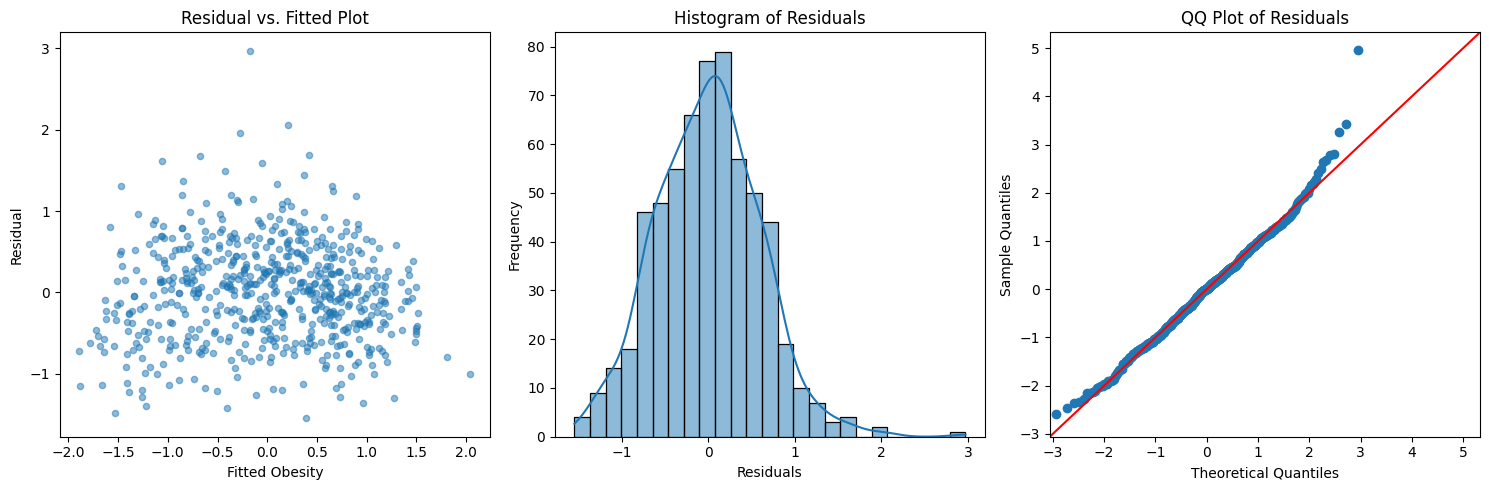

In [47]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# plot the graphs for model interpretion
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# residuals analysis
residuals = model_obesity.resid
# 1. Residuals vs. Fitted plot
axes[0].scatter(model_obesity.fittedvalues, residuals, alpha=0.5, s=20)
axes[0].set_xlabel('Fitted Obesity')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual vs. Fitted Plot')
# 2. Histogram of Residuals
sn.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title("Histogram of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Frequency")
# 3. QQ Plot of Residuals（Test for normality of residuals）
fig = sm.qqplot(residuals, fit=True, line="45", ax=axes[2])
plt.title('QQ Plot of Residuals')

plt.tight_layout()
#plt.savefig("Fit and Residual Diagnostics.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# Rainbow test: Check whether the linearity assumption of the linear regression model is established
test_rainbow = statsmodels.stats.diagnostic.linear_rainbow(model_obesity)
# This function returns a tuple consisting of two values: the test statistic based on the F test and the pvalue of the test
# Note that these two values are not named. Therefore, you need to know the order before accessing these two values.
print("The p value of the rainbow test: {:.4f}".format(test_rainbow[1]))

The p value of the rainbow test: 0.1797


In [49]:
# Jarque-Bera (JB) Test: Test whether the normality assumption of the residuals of the regression model is established.
test_JB = statsmodels.stats.stattools.jarque_bera(model_obesity.resid)
print("The p value of the Jarque Bera test: {:.4f}".format(test_JB[1]))

The p value of the Jarque Bera test: 0.0000


In [50]:
# Durbin-Watson (DW) Test: Detect autocorrelation(especially first-order autocorrelation) in the residuals of the regression model.
test_dw = statsmodels.stats.stattools.durbin_watson(model_obesity.resid)
print("Durbin-Watson test statistic is: {:.4f}".format(test_dw))

Durbin-Watson test statistic is: 1.7518
